# First Look at $^{83m}Kr$ Data in XENON1T
Dan Alexander, Ted Berger; July 27, 2016

In [3]:
from Kr83m_Basic_v3 import *        # pax minitree class for Kr83m data
from cut_helpers import *        # functions to apply and plot some event selections
from lce_helpers_v2 import *        # functions for binning, building map files, and plotting LCE maps

import numpy as np
import pandas as pd
import glob

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rc('font', size=16)

import hax
hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = '/project/lgrandi/xenon1t/raw/',
         main_data_paths='project/lgrandi/xenon1t/processed/pax_v5.5.0/')
#hax.ipython.code_hider()

# Table of Contents
[1 - Introduction](#introduction)  
[2 - Data and Event Selection](#data_and_selection)  
[3 - LCE Maps](#lce_maps)  
[4 - References](#references) 

<a id='introduction'></a>
# Introduction

As an internal calibration, $^{83m}Kr$ proves very useful in a variety of liquid noble detectors. We utilize a solution of $^{83}Rb$ evaporated onto zeolite beads to generate $^{83m}Kr$ with a half-life of $86.2\ days$. From there, $^{83m}Kr$, with a half-life of $1.83\ hr$, generates a $32.1\ keV$ conversion electron, followed by a $9.4\ keV$ conversion electron with a delay half-life of $154.4\ ns$. This decay scheme is shown in Figure 0.

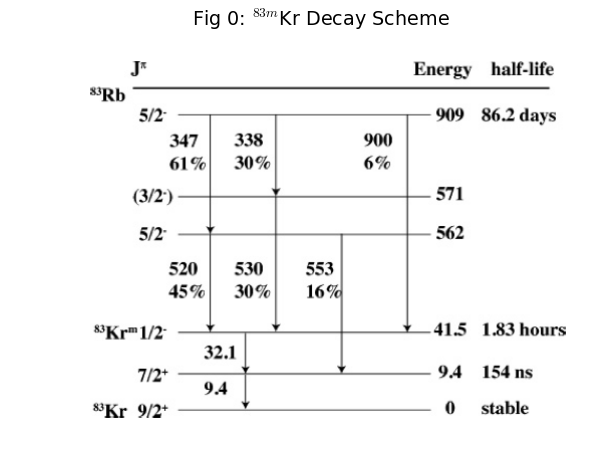

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)  

plt.imshow(mpimg.imread('kr83m_decay_scheme.png'))
plt.title('Fig 0: $^{83m}$Kr Decay Scheme')
plt.axis('off')
plt.show()

The short half-life of $^{83m}Kr$ and its mother permit an internal calibration without introducing unwanted signals into the experiment. Furthermore, the short half-life between the $32.1\ keV$ and $9.4\ keV$ calibration lines provides a unique signal that is essentially background free.

This is just a first look at the $^{83m}Kr$ data in XE1T, with the intent to do a more thorough analysis to follow soon.

<a id='data_and_selection'></a>
# Background Data and Understanding Event Selection

In [5]:
datasets_background = ['160808_0547', '160808_0447', '160808_0347', '160808_0046', 
                       '160807_2045', '160807_1945', '160807_1845', '160807_1745',
                       '160807_1645']
# load minitrees
# throws error when building minitrees for many datasets, I built them one by one

data = hax.minitrees.load(datasets_background, treemakers=Kr83m_Basic_v3)
df_pax = pd.DataFrame(data[data['s10Time']>=0]) # remove NaNs

In [6]:
# acceptance after restrictions

print(len(df_pax.values),'/',len(data.values),'=',len(df_pax.values)/len(data.values))

53653 / 304436 = 0.17623737008763746


In [7]:
# Add some colums to dataframes for easy cut comparison
for df in [df_pax]:
    df['s1Dt'] = df['s11Time']-df['s10Time']
    df['s1Gap'] = df['s11LeftEdge']-df['s10RightEdge']
    df['s20Width'] = df['s20RightEdge']-df['s20LeftEdge']
    df['s1sSpan'] = df['s11RightEdge']-df['s10LeftEdge']
    df['s1s2Deficit'] = df['s20Width']-df['s1sSpan']
    df['s1sRatio'] = df['s11Area']/df['s10Area']

In [8]:
# for plot of background s11/s10 w/ dt cut

dt_cut = [['s1Dt',500,2000,50,-1000,5000,'ns']]

df_pax_dt_cut = df_pax_cut = apply_cuts(df_pax,dt_cut)



In [9]:
# Kr Cuts

cuts = [ ['s1sRatio',0.1,1.0,50,0,1.2,'PE/PE'] , ['s1Dt',500,2000,50,-1000,5000,'ns'] ]

df_pax_cut = apply_cuts(df_pax,cuts)

print(len(df_pax_cut.values),'/',len(data.values),'=',len(df_pax_cut.values)/len(data.values))

161 / 304436 = 0.0005288467855312775


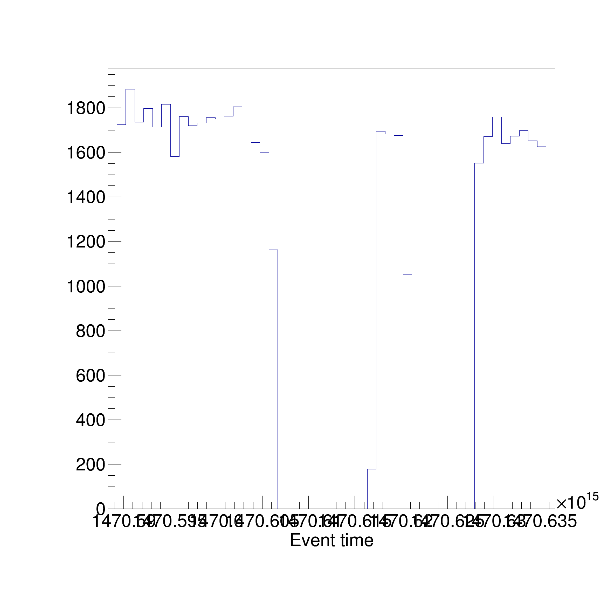

In [11]:
rates = []
for i in range(len(df_pax.values)):
    rates.append(df_pax['event_time'].values[i][0])
    
rate_hist = ROOT.TH1D('','',50,min(rates),max(rates))

for i in range(len(df_pax.values)):
    rate_hist.Fill(rates[i])
    
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)

rate_hist.GetXaxis().SetTitle('Event time')
rate_hist.GetXaxis().CenterTitle()
rate_hist.Draw('hist')

c1.Print('./Xe1T_Kr_Figures/test_rate.png')
c1.Clear()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/test_rate.png'))
plt.axis('off')
plt.show()


In [ ]:
h_s1s_pax = ROOT.TH2D('','',50,0,10000,50,0,500)

for i in range(len(df_pax_dt_cut.values)):
    h_s1s_pax.Fill(df_pax_dt_cut['s10Area'].values[i],df_pax_dt_cut['s11Area'].values[i])
    
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)
c1.SetLogz

h_s1s_pax.GetXaxis().SetTitle('s10Area (PE)')
h_s1s_pax.GetXaxis().CenterTitle()
h_s1s_pax.GetYaxis().SetTitle('s11Area (PE)')
h_s1s_pax.GetYaxis().SetTitleOffset(1.4)
h_s1s_pax.GetYaxis().CenterTitle()
#h_s1s_pax.SetTitle()
h_s1s_pax.Draw('colz')
#cut_line1 = ROOT.TLine(0.0,0.0,5000.0,500)
#cut_line1.Draw()


c1.Print('./Xe1T_Kr_Figures/f_s1sHists_before.png')
c1.Clear()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/f_s1sHists_before.png'))
plt.title('Figure 2: $s10Area\ vs.\ s11Area$ in Background Data')
plt.axis('off')
plt.show()


In [ ]:
h_xy_pax = ROOT.TH2D('','',50,-50,50,50,-50,50)
for i in range(len(df_pax_cut.values)):
    h_xy_pax.Fill(df_pax_cut['i0x'].values[i],df_pax_cut['i0y'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)

c1.SetLogz
h_xy_pax.GetXaxis().SetTitle('x (cm)')
h_xy_pax.GetXaxis().CenterTitle()
h_xy_pax.GetYaxis().SetTitle('y (cm)')
h_xy_pax.GetYaxis().CenterTitle()
h_xy_pax.SetTitle('Pax x vs. y Histogram')
h_xy_pax.SetMaximum(3e2)
h_xy_pax.Draw('colz')

c1.Print('./Xe1T_Kr_Figures/f_xyHists.png')
c1.Clear()


In [ ]:
h_rrz_pax = ROOT.TH2D('','',50,0,2500,50,-100,0)

for i in range(len(df_pax_cut.values)):
    rr = df_pax_cut['i0x'].values[i]**2+df_pax_cut['i0y'].values[i]**2
    h_rrz_pax.Fill(rr,df_pax_cut['i0z'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)
c1.SetLogz
h_rrz_pax.GetXaxis().SetTitle('r^{2} (cm^{2})')
h_rrz_pax.GetXaxis().CenterTitle()
h_rrz_pax.GetYaxis().SetTitle('z (cm)')
h_rrz_pax.GetYaxis().CenterTitle()
h_rrz_pax.SetTitle('Pax\ r^{2}\ vs.\ z\  Histogram')
h_rrz_pax.SetMaximum(3e2)
h_rrz_pax.Draw('colz')

c1.Print('./Xe1T_Kr_Figures/f_rrzHists.png')
c1.Clear()


In [ ]:
h_z_pax = ROOT.TH1D('','',50,-35,5)
    
for i in range(len(df_pax_cut.values)):
    h_z_pax.Fill(df_pax_cut['i0z'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)

c1.SetLogz

h_z_pax.GetXaxis().SetTitle('z (cm)')
h_z_pax.GetXaxis().CenterTitle()
h_z_pax.SetTitle('Pax z Histogram')
h_z_pax.SetMaximum(6e3)
h_z_pax.Draw()

c1.Print('./Xe1T_Kr_Figures/f_zHists.png')
c1.Clear()


In [ ]:
h_s1s_pax = ROOT.TH2D('','',50,0,2000,50,0,200)

for i in range(len(df_pax_cut.values)):
    h_s1s_pax.Fill(df_pax_cut['s10Area'].values[i],df_pax_cut['s11Area'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)
c1.SetLogz

h_s1s_pax.GetXaxis().SetTitle('s10Area (PE)')
h_s1s_pax.GetXaxis().CenterTitle()
h_s1s_pax.GetYaxis().SetTitle('s11Area (PE)')
h_s1s_pax.GetYaxis().SetTitleOffset(1.2)
h_s1s_pax.GetYaxis().CenterTitle()
h_s1s_pax.SetTitle('Pax s10Area vs. s11Area Histogram')
h_z_pax.SetMaximum(5e3)
h_s1s_pax.Draw('colz')
cut_line1 = ROOT.TLine(0.0,0.0,20000.0,2000)


c1.Print('./Xe1T_Kr_Figures/f_s1sHists.png')
c1.Clear()


In [ ]:
h_dt_pax = ROOT.TH1D('','',70,400,1100)

for i in range(len(df_pax_cut.values)):
    h_dt_pax.Fill(df_pax_cut['s1Dt'].values[i])

In [ ]:
def expDec(x,p):
    f = p[2]+p[0]*np.exp(-np.log(2)*x[0]/p[1])
    return f

In [ ]:
fitFun = ROOT.TF1("fitFun",expDec,500,1000,3)
fitFun.SetParameter(0,200000)
fitFun.SetParameter(1,155)
fitFun.SetParameter(2,10)

c1 = ROOT.TCanvas('','',1600,1200)
ROOT.gStyle.SetOptStat(0)

c1.SetLogy()
h_dt_pax.GetXaxis().SetTitle('s11Time - s10Time (ns)')
h_dt_pax.GetXaxis().CenterTitle()
h_dt_pax.SetTitle('Pax s1Dt Histogram')
h_dt_pax.SetMaximum(2e4)
h_dt_pax.Draw()
h_dt_pax.Fit("fitFun","","",500,1000)
fit2 = h_dt_pax.GetFunction("fitFun")
chi22 = fit2.GetChisquare()
ndf2 = fit2.GetNDF()
p12 = fit2.GetParameter(1)
e12 = fit2.GetParError(1)
pt2 = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
pt2.AddText("t_{1/2}=%1.3f"%p12)
pt2.AddText("#sigma=%1.3f"%e12)
pt2.AddText("#chi^{2}/NDF=%1.3f/%i"%(chi22,ndf2))
pt2.Draw()

c1.Print('./Xe1T_Kr_Figures/f_dtHists.png')
c1.Clear()


In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)  

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/f_xyHists.png'))
plt.title('Fig 9: $x\ vs.\ y$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/f_rrzHists.png'))
plt.title('Fig 10: $r^2\ vs.\ z$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/f_s1sHists.png'))
plt.title('Fig 11: $s10Area\ vs.\ s11Area$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/f_dtHists.png'))
plt.title('Fig 12: $s1Dt$ Histograms')
plt.axis('off')
plt.show()

<a id='lce_maps'></a>
# LCE Maps

In [ ]:
R = 47.9
Z = -96.7
A_r = [R/3, 2*R/3, R]
N_phi = [4, 6, 10]
N_z = 5
bin_settings = [R,Z,A_r,N_phi,N_z]

In [ ]:
bin_data_s10_pax = xe_to_lyBins(df_pax,bin_settings,'s10',bin_spec_dir='Bin_Hists_s10_pax') # for Pax

In [ ]:
plt.imshow(mpimg.imread('Bin_Hists_s10_pax/f_s10_z0_r0_phi5.png'))
plt.title('Fig 13b: Pax S10 Spectra for a Single Top Bin')
plt.axis('off')
plt.show()


plt.imshow(mpimg.imread('Bin_Hists_s10_pax/f_s10_z5_r4_phi29.png'))
plt.title('Fig 14b: Pax S10 Spectra for a Single Middle Bin')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('Bin_Hists_s10_pax/f_s10_z9_r2_phi5.png'))
plt.title('Fig 15b: Pax S10 Spectra for a Single Bottom Bin')
plt.axis('off')
plt.show()

In [ ]:
bins_to_plot(bin_data_s10_pax, 's10', bin_settings, 'pax_s10_maps.png')

plt.rcParams['figure.figsize'] = (30.0, 30.0)  

plt.imshow(mpimg.imread('pax_s10_maps.png'))
plt.axis('off')
plt.show()

In [ ]:
h_2d_lce = ROOT.TH2D('','',50,0,2500,50,-100,0)

rr = df_pax_cut['i0x'].values[i]**2+df_pax_cut['i0y'].values[i]**2

for i in range(len(df_pax_cut.values)):
    h_2d_lce.Fill(rr, df_pax_cut['i0z'].values[i],
                    df_pax_cut['cs10Area'].values[i]/32.1)



In [ ]:
c1 = ROOT.TCanvas('','',1600,1600)
ROOT.gStyle.SetOptStat(0)
h_2d_lce.GetXaxis().SetTitle('r^{2} (cm^{2})')
h_2d_lce.GetXaxis().CenterTitle()
h_2d_lce.GetYaxis().SetTitle('z (cm)')
h_2d_lce.GetYaxis().CenterTitle()
h_2d_lce.SetTitle('Pax 2d Light Yield')
h_2d_lce.Draw('colz')

c1.Print('./Xe1T_Kr_Figures/2d_lce.png')
c1.Clear()

plt.imshow(mpimg.imread('Xe1T_Kr_Figures/2d_lce.png'))
plt.axis('off')
plt.show()

We begin with the same binning originally used by Cecilia for the $^{137}Cs$ LCE maps and again by Richard for the $^{83m}Kr$ LCE maps in Xerawdp. For each of these bins, we pull the mean S1 area from a Gaussian fitted to data. Figure 13 shows some examples of the S1 spectra that are used to extract LY values.

<a id='references'></a>
# References

[[1] S. -C. Wu, Nuclear Data Sheets 92, 893 (2001)](nucleardatasheets_a83.pdf)  